<a href="https://colab.research.google.com/github/overtunned/Named-Entity-Recognition-and-entity-network/blob/main/ner-with-bi-lstm-crf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/overtunned/Named-Entity-Recognition-and-entity-network.git

Cloning into 'Named-Entity-Recognition-and-entity-network'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 5), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
import pandas as pd
import numpy as np
import re
import string

data = pd.read_csv("/content/Named-Entity-Recognition-and-entity-network/Dataset/ner_dataset.csv", encoding="latin1")

In [3]:
data = data.fillna(method="ffill")

In [4]:
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [6]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)

In [9]:
sent = getter.get_next()

In [10]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [11]:
sentences = getter.sentences

## Prepare the data
Now we introduce dictionaries of words and tags.

In [12]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
word2idx["Obama"]

32357

In [14]:
tag2idx["B-geo"]

7

In [15]:
from keras.preprocessing.sequence import pad_sequences

# pad the sequence
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [16]:
# pad the target
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [20]:
from keras.utils.np_utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

## Setup the CRF-LSTM
Now we can fit a LSTM-CRF network with an embedding layer.



In [21]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-gwbdrmpj
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-gwbdrmpj
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=0f9c3116d5e7eabb2ac8831a6b9093d88833627bc7a139c522f8f0d2dc064fa7
  Stored in directory: /tmp/pip-ephem-wheel-cache-m3djxna9/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [22]:
from keras.models import Model, Input,Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
import keras as k

In [23]:
print(k.__version__)

2.5.0


In [24]:
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=200, input_length=max_len))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="relu")))
crf_layer = CRF(n_tags)
model.add(crf_layer)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 75, 200)           7036000   
_________________________________________________________________
dropout (Dropout)            (None, 75, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 256)           336896    
_________________________________________________________________
time_distributed (TimeDistri (None, 75, 17)            4369      
_________________________________________________________________
crf (CRF)                    (None, 75, 17)            629       
Total params: 7,377,894
Trainable params: 7,377,894
Non-trainable params: 0
_________________________________________________________________


In [28]:
# adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=128, epochs=5,
                    validation_split=0.1, verbose=1)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38847 samples, validate on 4317 samples
Epoch 1/5
38847/38847 [==============================] - 76s 2ms/step - loss: 0.3055 - crf_viterbi_accuracy: 0.9276 - val_loss: 0.0855 - val_crf_viterbi_accuracy: 0.9732
Epoch 2/5
38847/38847 [==============================] - 73s 2ms/step - loss: 0.0626 - crf_viterbi_accuracy: 0.9789 - val_loss: 0.0457 - val_crf_viterbi_accuracy: 0.9842
Epoch 3/5
38847/38847 [==============================] - 73s 2ms/step - loss: 0.0300 - crf_viterbi_accuracy: 0.9877 - val_loss: 0.0251 - val_crf_viterbi_accuracy: 0.9877
Epoch 4/5
38847/38847 [==============================] - 72s 2ms/step - loss: 0.0134 - crf_viterbi_accuracy: 0.9906 - val_loss: 0.0150 - val_crf_viterbi_accuracy: 0.9888
Epoch 5/5
38847/38847 [==============================] - 68s 2ms/step - loss: 0.0033 - crf_viterbi_accuracy: 0.9919 - val_loss: 0.0077 - val_crf_viterbi_accuracy: 0.9893


In [ ]:
hist = pd.DataFrame(history.history)

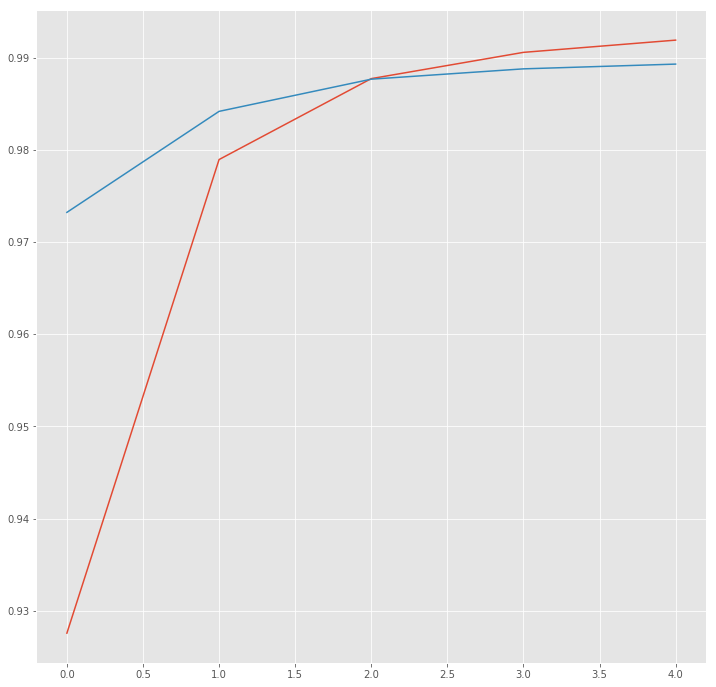

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 1.5MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16172 sha256=8f7a9a4ea4218357f6c88526d05e95df8f1155f1a8456cb6049a15ba09571480
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
test_pred = model.predict(X_te, verbose=1)

4797/4797 [==============================] - 8s 2ms/step


In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 80.6%


In [ ]:
print(classification_report(test_labels, pred_labels))

/opt/conda/lib/python3.6/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        42
         eve       0.00      0.00      0.00        32
         geo       0.84      0.88      0.86      3718
         gpe       0.95      0.93      0.94      1583
         nat       0.00      0.00      0.00        17
         org       0.68      0.64      0.66      2028
         per       0.75      0.71      0.73      1814
         tim       0.89      0.80      0.84      2003

   micro avg       0.82      0.79      0.81     11237
   macro avg       0.51      0.49      0.50     11237
weighted avg       0.81      0.79      0.80     11237



In [ ]:
model.evaluate(X_te, np.array(y_te))

4797/4797 [==============================] - 9s 2ms/step


[0.006730068376381397, 0.9893738627433777]

In [ ]:
i = 1927
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
Jankovic       : B-org B-per
is             : O     O
the            : O     O
second         : O     O
war            : O     O
crimes         : O     O
suspect        : O     O
to             : O     O
be             : O     O
transferred    : O     O
from           : O     O
The            : B-org B-org
Hague          : I-org I-org
Tribunal       : I-org I-org
to             : O     O
Bosnia         : B-geo B-geo
's             : O     O
war            : O     O
crimes         : O     O
court          : O     O
.              : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
Mobutu         : O     O
M

In [ ]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [ ]:
test_sentence="In the context of prehistory, antiquity and contemporary indigenous peoples, the title may refer to tribal kingship. Germanic kingship is cognate with Indo-European traditions of tribal rulership (c.f. Indic rājan, Gothic reiks, and Old Irish rí, etc.)."
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=0, maxlen=max_len)

In [ ]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(test_sentence), p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
In             : O    
the            : O    
context        : B-org
of             : O    
prehistory     : O    
,              : O    
antiquity      : O    
and            : O    
contemporary   : O    
indigenous     : O    
peoples        : O    
,              : O    
the            : O    
title          : O    
may            : O    
refer          : O    
to             : O    
tribal         : O    
kingship       : O    
.              : O    
Germanic       : B-org
kingship       : I-org
is             : O    
cognate        : O    
with           : O    
Indo           : O    
-              : O    
European       : O    
traditions     : O    
of             : O    
tribal         : O    
rulership      : O    
(              : O    
c              : B-org
.              : O    
f              : B-geo
.              : O    
Indic          : B-geo
rājan          : I-geo
,              : O    
Gothic         : B-geo
reiks          : I-geo
,     

In [ ]:
# our code start from here...............................................................
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Bidirectional
from numpy import array
import spacy
import pandas as pd
import random


#from config import *
lstm_unit=64
epochs=10
loss='categorical_crossentropy'
optimizer='adam'
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
sentence="Perfect your shooting skills with the Spalding Back Atcha Ball Return Training Aid. Designed with solo practice days in mind, this training aid attaches to your rim and serves the ball right back to you after your shot goes down.THE ATKINS MISSION. Atkins’ purpose is to improve global health and to help people understand that eating right is about both losing weight and becoming healthy. That’s done through the use of imagination, innovation, partnerships and commitment to science to make it easy to eat right. VANILLA LATTE SHAKE. Atkins protein shakes help support your low carb lifestyle without compromising flavor. Made with real instant coffee and sweet vanilla flavor, this gluten free iced coffee shake delivers the boost and flavor you crave with none of the guilt. For a quick breakfast or a mid-day recharge, reach for this keto-friendly** shake to satisfy hunger. **When used with Atkins ketogenic programs WHAT’S INSIDE. Let this rich and creamy shake delight your taste buds while delivering essential vitamins and minerals and as much caffeine as a cup of coffee*. Includes 3 packs, each with 4 ready-to-drink 11 oz shakes with 15 grams of high-quality protein, 5 grams of fiber, 4 grams of net carbs and 1 gram of sugar per serving. *Caffeine content per shake as compared to a standard 8 fl oz cup of brewed coffee EAT RIGHT. NOT LESS. Cardiologist Dr. Robert C. Atkins saw that eating right, not less, improved his patients’ health - not just in terms of weight loss but also reducing chronic issues. Over the last 45 years, mounting evidence is revealing that Dr. Atkins was right. PUBLIC HEALTH ADVOCACY. The “Atkins Diet” started as a fad, but quickly became a counter-conventional movement that reset people’s understanding of nutrition and weight loss, and its link to health. Atkins public health advocacy has played a significant role in updating dietary guidelines, moving them from less and towards right."

nlp = spacy.load('en_core_web_sm')
model_emb = hub.load(module_url)
sentences = [str(i) for i in nlp(sentence).sents]
y=array([random.randint(0,1) for i in range(len(sentences))])

In [ ]:
!pip show spacy

Name: spacy
Version: 2.2.3
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /opt/conda/lib/python3.6/site-packages
Requires: wasabi, srsly, setuptools, thinc, requests, preshed, numpy, murmurhash, catalogue, plac, cymem, blis
Required-by: pykoko, fastai, en-core-web-sm, en-core-web-lg, allennlp


In [ ]:
from keras.preprocessing.sequence import pad_sequences
max_len=75
embedding=40
unique_words=set()
for sen in sentences:
    words=sen.split(" ")
    words=set(words)
    unique_words=unique_words.union(words)

word2inx={i:j+1 for j, i in enumerate(unique_words)}

X = [[word2inx[w] for w in s.split(" ")] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = len(word2inx)+1)
y_label=[[random.randint(0,1) for i in range(75)] for j in range(25)]
X=array(X)

In [ ]:
y = [to_categorical(i, num_classes=2) for i in y_label]
y_label=array(y).reshape(25,75,2)

In [ ]:
len(y_label)

25

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = 75, output_dim = embedding, input_length = max_len))
model.add(Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf_layer = CRF(2)
model.add(crf_layer)
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

model.summary()


/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 75, 40)            3000      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 75, 100)           60400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 75, 2)             110       
Total params: 104,960
Trainable params: 104,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
crf_layer.loss_function

<function keras_contrib.losses.crf_losses.crf_loss(y_true, y_pred)>

In [ ]:
y_label.shape

(25, 75, 2)

In [ ]:
model.fit(X,y_label, epochs=10)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
25/25 [==============================] - 3s 119ms/step - loss: 1.0367 - crf_viterbi_accuracy: 0.5077
Epoch 2/10
25/25 [==============================] - 0s 14ms/step - loss: 1.0246 - crf_viterbi_accuracy: 0.5077
Epoch 3/10
25/25 [==============================] - 0s 14ms/step - loss: 1.0084 - crf_viterbi_accuracy: 0.5077
Epoch 4/10
25/25 [==============================] - 0s 15ms/step - loss: 0.9878 - crf_viterbi_accuracy: 0.5077
Epoch 5/10
25/25 [==============================] - 0s 13ms/step - loss: 0.9629 - crf_viterbi_accuracy: 0.5077
Epoch 6/10
25/25 [==============================] - 0s 14ms/step - loss: 0.9332 - crf_viterbi_accuracy: 0.5077
Epoch 7/10
25/25 [==============================] - 0s 14ms/step - loss: 0.8974 - crf_viterbi_accuracy: 0.5077
Epoch 8/10
25/25 [==============================] - 0s 13ms/step - loss: 0.8577 - crf_viterbi_accuracy: 0.5077
Epoch 9/10
25/25 [==============================] - 0s 13ms/step - loss: 0.8174 - crf_viterbi_accuracy: 0.5077
